In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import time

In [47]:
df = pd.read_csv("df_working.csv")
#df = df.sample(n=500000, random_state=42)

/var/folders/_t/mfgk4xxn1hb8w2n3w5x65snw0000gp/T/ipykernel_22401/184150324.py:1: DtypeWarning: Columns (5,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_working.csv")


In [14]:
# Models to try
models = {
    # 'Linear Regression': LinearRegression(),
    # 'Ridge Regression': Ridge(),
    # 'Lasso Regression': Lasso(),
    #'Random Forest': RandomForestRegressor(),
    # 'Decision Tree': DecisionTreeRegressor(),
    # 'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(verbosity=0)
    # 'Support Vector': SVR()
}

print(df['TELEHEALTHFLAG'])

0          2.0
1          2.0
2          2.0
3          2.0
4          2.0
          ... 
1007501    NaN
1007502    NaN
1007503    NaN
1007504    NaN
1007505    NaN
Name: TELEHEALTHFLAG, Length: 1007506, dtype: float64


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define columns
feature_cols = [
    'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
    'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
    'OBDATEYR', 'OBDATEMM', 'insurance'
]

binary_cols = [
    'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
]

# Fill NA and convert to string initially
df[feature_cols] = df[feature_cols].fillna('Missing')
df[feature_cols] = df[feature_cols].astype(str)


# Map binary features to numeric
for col in binary_cols:
    df[col] = df[col].map({'1.0': 1, '2.0': 0, 'Missing': np.nan})

# Build model dataframe
df_model = df[feature_cols + ['total_charge', 'out_of_pocket', 'COST_COVERED']]
df_model['log_total_charge'] = np.log1p(df_model['total_charge'])

# Define inputs and targets
X = df_model[feature_cols]

targets = {
    'Total Cost': df_model['total_charge'],
    'Out-of-Pocket': df_model['out_of_pocket'],
    'Cost Covered': df_model['COST_COVERED']
}

# Identify categorical columns = object types EXCLUDING binary numeric cols
categorical_cols = list(set(X.select_dtypes(include='object').columns) - set(binary_cols))

# Preprocessor: Categorical = impute + encode, pass binary and other numerics through
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # Binary and numeric features stay as-is
)


['2.0' '1.0' 'Missing']
[ 0.  1. nan]


/var/folders/_t/mfgk4xxn1hb8w2n3w5x65snw0000gp/T/ipykernel_22401/442313141.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['log_total_charge'] = np.log1p(df_model['total_charge'])


In [39]:
print(df_model)

Empty DataFrame
Columns: [VISITTYPE, VSTCTGRY, DOCATLOC, DRSPLTY_M18, MEDPTYPE_M18, SEEDOC_M18, SURGPROC, MEDPRESC, TELEHEALTHFLAG, LABTEST_M18, XRAYS_M18, MRI_M18, EKG_M18, OBDATEYR, OBDATEMM, insurance, COST_COVERED]
Index: []


In [49]:
for target_name, y in targets.items():
    print(f"\n Prediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column (y is a Series with the correct column)
    df_model = pd.concat([X, y], axis=1)
    #df_with_na = df_model[df_model.isna().any(axis=1)]
    #print(df_with_na)
    #num_na_rows = df_model.isna().any(axis=1).sum()
    #print(f"{num_na_rows} rows contain at least one NA value.")
    df_model = df_model.dropna()



    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series

    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    for model_name, model in models.items():
    #for model_name, model in tqdm(models.items(), desc=f"Models for {target_name}", leave=False):
        start_model = time.time()
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        #print(f"{model_name:20} | RMSE: {rmse:8.2f} | R²: {r2:.4f}")
        duration = time.time() - start_model
        print(f"{model_name} done in {duration:.2f}s | RMSE: {rmse:.2f}, R²: {r2:.4f}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")



 Prediction: Total Cost
XGBoost done in 0.83s | RMSE: 3948.48, R²: -2.0755
✅ Finished Total Cost in 1.23s

 Prediction: Out-of-Pocket
XGBoost done in 0.77s | RMSE: 186.03, R²: 0.2293
✅ Finished Out-of-Pocket in 1.06s

 Prediction: Cost Covered
XGBoost done in 0.77s | RMSE: 4502.86, R²: -3.0589
✅ Finished Cost Covered in 1.08s


In [52]:
targets['Cost Covered'] = targets['Cost Covered'].clip(lower=0)

log_targets = {
    'Log Total Cost': np.log1p(targets['Total Cost']),
    'Log Out-of-Pocket': np.log1p(targets['Out-of-Pocket']),
    'Log Cost Covered': np.log1p(targets['Cost Covered'])
}

y_tests = []
y_preds = []

# Check for NaN or infinite values after log transformation
for target_name, y in log_targets.items():
    nan_count = y.isna().sum()
    inf_count = np.isinf(y).sum()
    print(f"{target_name}: {nan_count} NaNs, {inf_count} infinities")
    
    # Replace infinities with NaNs, then drop rows with NaNs
    log_targets[target_name] = y.replace([np.inf, -np.inf], np.nan)

# Modified training code with better error handling
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()  # Drop any rows with NaN values
    
    # Safety check - are there enough rows?
    if len(df_model) < 100:  # arbitrary threshold
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue

    # Check if any zeros in original data created -inf in log data
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series

    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    try:
        for model_name, model in models.items():
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            # Calculate metrics on transformed scale
            rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
            r2_log = r2_score(y_test, y_pred)
            
            # Try to calculate original scale metrics, but handle errors
            try:
                y_test_original = np.expm1(y_test)
                y_tests.append(y_test_original)
                y_pred_original = np.expm1(y_pred)
                y_preds.append(y_pred_original)
                rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                r2_original = r2_score(y_test_original, y_pred_original)
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale - RMSE: {rmse_original:.2f}, R²: {r2_original:.4f}")
            except:
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale metrics calculation failed")
    
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")

baseline = y_test.mean()
print(f"Baseline RMSE: {np.sqrt(mean_squared_error(y_test, [baseline] * len(y_test))):.2f}")


Log Total Cost: 0 NaNs, 0 infinities
Log Out-of-Pocket: 0 NaNs, 0 infinities
Log Cost Covered: 0 NaNs, 0 infinities

Prediction: Log Total Cost
XGBoost done in 0.77s
  Log scale - RMSE: 0.9462, R²: 0.2720
  Original scale - RMSE: 2233.16, R²: 0.0162
✅ Finished Log Total Cost in 1.16s

Prediction: Log Out-of-Pocket
XGBoost done in 0.77s
  Log scale - RMSE: 1.6110, R²: 0.3667
  Original scale - RMSE: 208.00, R²: 0.0366
✅ Finished Log Out-of-Pocket in 1.02s

Prediction: Log Cost Covered
XGBoost done in 0.77s
  Log scale - RMSE: 1.5820, R²: 0.3534
  Original scale - RMSE: 2230.15, R²: 0.0043
✅ Finished Log Cost Covered in 0.97s
Baseline RMSE: 1.97


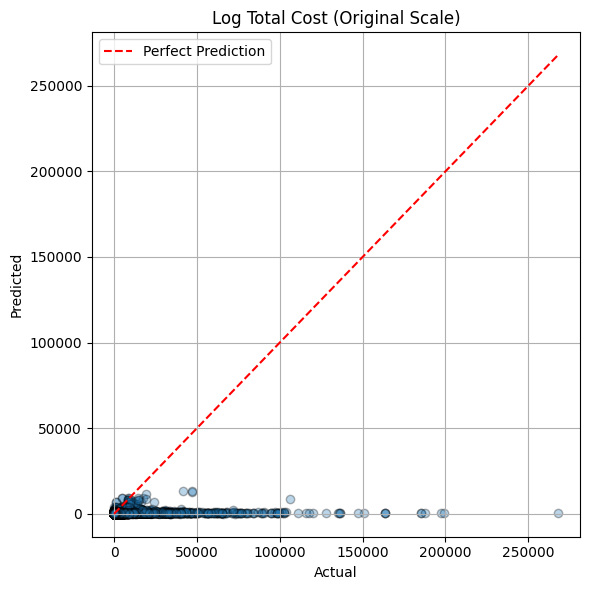

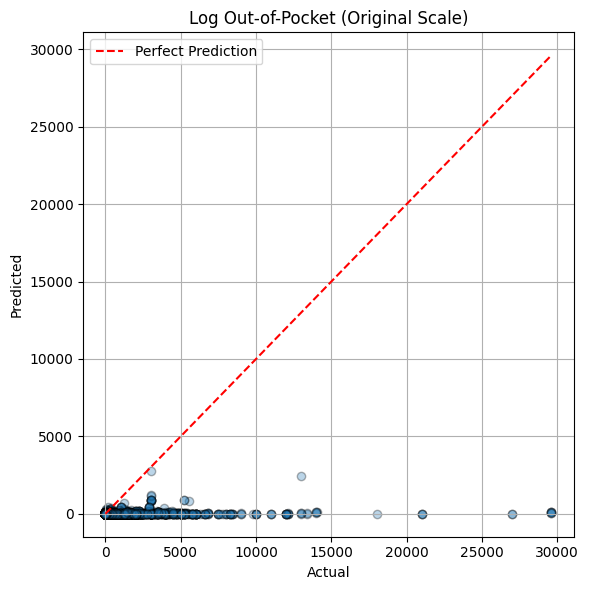

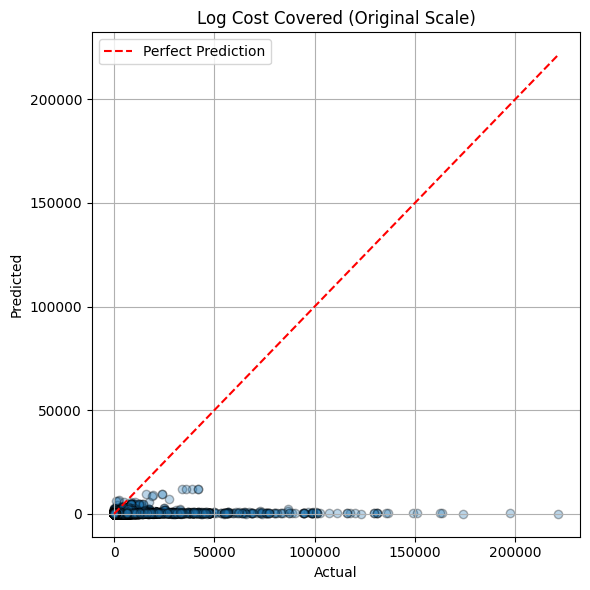

In [37]:
import matplotlib.pyplot as plt

# Assuming you used models.items() in the same order for each target
# and only one model per target was used (e.g., XGBoost only)
target_names = list(log_targets.keys())

for i in range(len(y_tests)):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_tests[i], y_preds[i], alpha=0.3, edgecolors='k')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f"{target_names[i]} (Original Scale)")
    max_val = max(y_tests[i].max(), y_preds[i].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
